<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/dendritic_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dendritic computation**

#### Installs & Imports

Fist, we install all the things we need again.

In [1]:
!pip install brian2 -q
!git clone https://github.com/DiGyt/neuropynamics/ -q

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 5.8MB 21.2MB/s 


Import everything we need.

In [2]:
import numpy as np
import networkx as nx
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from brian2 import (second, ms, us, volt, mV, cm, umetre, ufarad, siemens, msiemens, mA)
from brian2 import (start_scope, NeuronGroup, Synapses, SpikeGeneratorGroup,
                    StateMonitor, SpikeMonitor, run, defaultclock)

from neuropynamics.src.utils.plotting import (plot_cmesh, plot_signals,
                                              plot_spikes, plot_synapses)

WARNING    /usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
 [py.warnings]


## Step-by-step

First of all, we define a Hodgkin-Huxley neuron model.

In [3]:
model = '''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    '''   
# Define threshold and refractory period
threshold = 'v > 35*mV'
refractory = 'v > -40*mV'

area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area # Mebrane capacitance
gl = 5e-5*siemens*cm**-2 * area
El = -65.*mV
EK = -90.*mV
ENa = 50.*mV
g_na = 100.*msiemens*cm**-2 * area
g_kd = 30.*msiemens*cm**-2 * area
VT = -63*mV

In [4]:
start_scope()

left_pulse = 2.1 * ms
right_pulse = 2.9 * ms

N = 7

# define the left/right stimulus neurons
inputs = SpikeGeneratorGroup(2, indices=[0, 1], times=[left_pulse, right_pulse])

# Create a group of Izhikevich neurons
neurons = NeuronGroup(N, model=model,
                      threshold=threshold,
                      refractory=refractory,
                      method='exponential_euler')

# create the left group of synapses from Neuron 0 to the last five
synapses_0 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
synapses_0.connect(i=0, j=np.arange(N))
synapses_0.weight = 30 * mV
synapses_0.delay =  np.arange(N)/10 * ms

# create the right group of synapses from Neuron 0 to the last five
synapses_1 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
synapses_1.connect(i=1, j=np.arange(N))
synapses_1.weight = 30 * mV
synapses_1.delay =  np.arange(N, 0, -1)/10 * ms

run(2*ms)
# run the simulation while monitoring it
states = StateMonitor(neurons, 'v', record=True)
spikes = SpikeMonitor(neurons, 'v', record=True)
inp_spikes = SpikeMonitor(inputs, record=True)
run(3*ms)

First, we should inspect how the network that we've just build looks like.

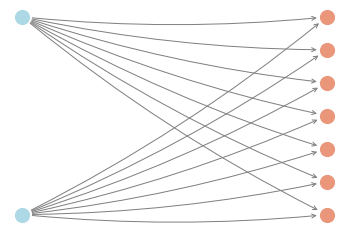

In [5]:
plot_synapses(neuron_groups=[inputs, neurons],
              synapse_groups=[synapses_0, synapses_1],
              pos_func=lambda x:nx.bipartite_layout(x, nodes=[0,1]), 
              color_cycle=["lightblue", "darksalmon"])

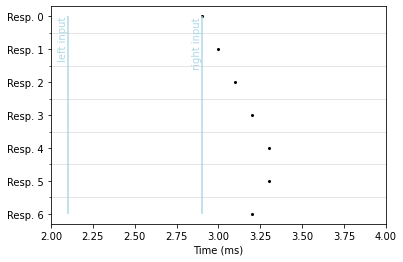

In [6]:
ch_names = ["Resp. " + str(i) for i in range(len(neurons))]
plot_spikes(spikes.i, spikes.t/ms, ch_names,time_unit="ms", show=False)
plt.xlim(2, 4)
plt.vlines(x=[left_pulse/ms, right_pulse/ms], ymin=0, ymax=len(neurons)-1, color = 'lightblue')
for name, time in zip(["left input", "right input"], [left_pulse, right_pulse]):
  plt.text(time/ms, len(neurons)-1, name, rotation=90, c="lightblue",
          verticalalignment="top", horizontalalignment="right")

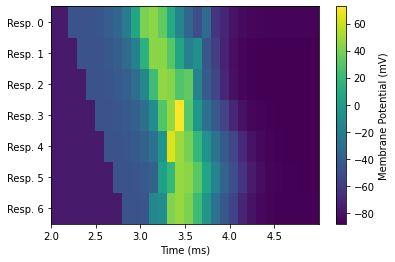

In [7]:
plot_cmesh(states.v/mV, states.t/ms, ch_names, time_unit="ms", unit="Membrane Potential (mV)")

## Try it out yourself

Here we will put all of the above into one interactive function, so you can play around with the timing of the left and right input.

In [14]:
model = '''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    '''   
# Define threshold and refractory period
threshold = 'v > -40*mV'
refractory = 'v > -40*mV'

area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area # Mebrane capacitance
gl = 5e-5*siemens*cm**-2 * area
El = -65.*mV
EK = -90.*mV
ENa = 50.*mV
g_na = 100.*msiemens*cm**-2 * area
g_kd = 30.*msiemens*cm**-2 * area
VT = -63*mV


defaultclock.dt = 0.05*ms

def dendritic_computation(left, right, N):

  start_scope()

  left_pulse = left * ms
  right_pulse = right * ms

  # define the left/right stimulus neurons
  inputs = SpikeGeneratorGroup(2, indices=[0, 1], times=[left_pulse, right_pulse])

  # Create a group of Izhikevich neurons
  neurons = NeuronGroup(N, model=model,
                        threshold=threshold,
                        refractory=refractory,
                        method='exponential_euler')

  # create the left group of synapses from Neuron 0 to the last five
  synapses_0 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
  synapses_0.connect(i=0, j=np.arange(N))
  synapses_0.weight = 30 * mV
  synapses_0.delay =  np.arange(N)/10 * ms

  # create the right group of synapses from Neuron 0 to the last five
  synapses_1 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
  synapses_1.connect(i=1, j=np.arange(N))
  synapses_1.weight = 30 * mV
  synapses_1.delay =  np.arange(N, 0, -1)/10 * ms

  run(2*ms)
  # run the simulation while monitoring it
  states = StateMonitor(neurons, 'v', record=True)
  spikes = SpikeMonitor(neurons, 'v', record=True)
  inp_spikes = SpikeMonitor(inputs, record=True)
  run(3*ms)

  # plot the network
  plt.figure(figsize=[15,5])
  plt.subplot(1, 3, 1)
  plt.title("Network Layout")
  plot_synapses(neuron_groups=[inputs, neurons],
                synapse_groups=[synapses_0, synapses_1],
                pos_func=lambda x:nx.bipartite_layout(x, nodes=[0,1]), 
                color_cycle=["lightblue", "darksalmon"], show=False)

  # plot the spiking times
  plt.subplot(1, 3, 2)
  plt.title("Spiking Times")
  ch_names = ["Resp. " + str(i) for i in range(len(neurons))]
  plot_spikes(spikes.i, spikes.t/ms, ch_names,time_unit="ms", show=False)
  plt.xlim(2, 4)
  plt.vlines(x=[left_pulse/ms, right_pulse/ms], ymin=0, ymax=len(neurons)-1, color = 'lightblue')
  for name, time in zip(["left input", "right input"], [left_pulse, right_pulse]):
    plt.text(time/ms, len(neurons)-1, name, rotation=90, c="lightblue",
            verticalalignment="top", horizontalalignment="right")

  # plot the membrane potential
  plt.subplot(1, 3, 3)
  plt.title("Membrane Potential")
  plot_cmesh(states.v[:, states.t >= 2*ms]/mV, states.t[states.t >= 2*ms]/ms, ch_names, time_unit="ms", unit="Membrane Potential (mV)", show=False)


layout = {'width': '500px'}; style = {'description_width': '200px'}
left_slider = FloatSlider(value = 2., min= 2., max = 4., step = 0.01, description = 'Left input spike (ms):', continuous_update=False, layout=layout, style=style)
right_slider = FloatSlider(value = 2., min= 2., max = 4., step = 0.01, description = 'Right input spike (ms):', continuous_update=False, layout=layout, style=style)
N_slider = IntSlider(value = 10, min= 0, max = 20, step = 1, description = 'Number of response neurons:', continuous_update=False, layout=layout, style=style)

interactive(dendritic_computation, left=left_slider, right=right_slider, N=N_slider)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='Left input spike (ms):', la…

### archive

In [9]:
import seaborn as sns

# Plotting function
def create_default_plot(x, neuron_data, neuron_labels, neuron_colors, spikes = None, spike_color = 'steelblue', input_current = None, input_label = 'Input Current', input_color = 'gold', y_range = None, title = '', x_axis_label = '', y_axis_label = '', input_axis_label = 'Input Current (A)', hline = None, sns_style=True):
    
  # Apply default seaborn settings
  if sns_style:
    sns.set()
    sns.set_style({'axes.grid' : False})

  # Create first y axis and set size of figure
  fig, ax1 = plt.subplots(figsize=(14,6))

  # Set axis labels
  ax1.set_xlabel(x_axis_label)
  ax1.set_ylabel(y_axis_label)

  # Set y range if given
  if y_range is not None:
      ax1.set_ylim(y_range)

  # Add horizontal line
  if hline is not None:
      ax1.axhline(y = hline, linestyle = '--', linewidth = 1, color = 'gray', label = 'Spiking Threshold')

  # Plot a line for each neuron datapoint
  for idx, y in enumerate(neuron_data):
      # We ignore the first datapoint as these are always 0 and result in weird looking lines
      ax1.plot(x[1:], y[1:], color = neuron_colors[idx], label = neuron_labels[idx])

  # Plot spikes if given
  if spikes is not None:
      # Ignore the first spike if it is before 100ms (as no current was given)
      if spikes[0] >= 10:
          ax1.axvline(spikes[0], linestyle = ':', color = spike_color, linewidth = 1, zorder = 0)
      for t in spikes[1:-1]:
          ax1.axvline(t, linestyle = ':', color = spike_color, linewidth = 1, zorder = 0)
      # Add line for last spike with label
      ax1.axvline(spikes[-1], linestyle = ':', color = spike_color, linewidth = 1, label = 'Spikes', zorder = 0)

  # Show input current if given
  if input_current is not None:
      # Create 2nd y-axis
      ax2 = ax1.twinx()
      # Set axis label
      ax2.set_ylabel(input_axis_label)
      # Draw input line
      ax2.plot(x, input_current, color = input_color, label = input_label)   
  
  # Add legend
  fig.legend(loc="upper right", bbox_to_anchor=(0.825, 0.8))

  # Set title
  plt.title(title)